# INFR 3700U Assignment 1 Fall 2024

# Total: /100

## Instructions

* Complete the Lab assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the Lab assignment.



This notebook contains the questions for Assignment 1. Please note, a random seed has been set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**. Make sure to complete this assignment individually and appropriately reference all external code and documentation used. Using AI chatbots (e.g., ChatGPT) to generate the code is NOT allowed and will be considered plagiarism.

In [1]:
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, accuracy_score, precision_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
np.random.seed(42)

## Data set 

This assignment's objective is to develop a data-driven predictive model for the power consumption of an industrial refrigeration system using the `Data_Rack01` dataset.  
The data frame contains the following data, where each row represents a datapoint:

- Dew_Point: the temperature to which air must be cooled to become saturated with water vapor 
- Indoor_Humidity: The indoor Humidity
- Indoor_Temperature: The indoor temprature (Fahrenheit)
- Outdoor_Humidity: The outdoor humidity
- Outdoor_Temperature: The outdoor temprature (Fahrenheit)
- Discharge_Pressure: The pressure generated on the output side of a gas compressor in a refrigeration system
- Discharge_Temperature: The compressor's discharge temperature 
- KW: Power consumed
- Power_Factor: The power factor of the refrigeration system
- Volts_Line_to_Line
- Volts_Line_to_Neutral

## Question 1 (40 pts)

### a) Preprocess the data acording to the following:

1. Load data into a variable called myData
2. In the `myPreProc` function perform the following:
  - Remove the empty column(s), 
  - Drop rows with any missing data ("NA").
  - Remove the 'DeviceName' column as well

The processed data should be returned through the function variable `procData`

### b) Define two loss functions:
- one that measures the absolute difference between observations and predictions. Return mean of the result.
- one that finds the absolute difference that is less than or equal to a threshold. Return mean of the result.

### c) Data splitting:
- Use power consumption as the target variable for your machine learning model. 
- Split your preprocessed dataset by setting aside some amount of data for testing, and retaining the rest for training. Reserve 30 percent of your data for testing. *Make sure to set the random_state to 42 if you are using an sklearn function to accomplish this. 


### d) Build a linear regression model:
- Build a model to predict power consumed (KW) as a `linear function` of the other variables (features) in the dataset. In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that standardizes the features and creates a linear regression model.
- Report the coefficient of determination (`R2 score`) when evaluating both the training and testing performance of your model.

In [2]:
#Part 1a

#load data
myData=pd.read_csv('Data_Rack01.csv')

def myPreProc(data):
    remCol = data.dropna(how= "all", axis=1)
    dropRow = remCol.dropna()
    procData = dropRow.drop(labels='DeviceName',axis=1)
    return procData

procData=myPreProc(myData)


In [3]:
#Part 1b

def abs_diff_loss(obs, pred):
    
    #write function
    resids = abs(obs-pred)
    return resids.mean()

def threshold_loss(obs, pred, thresh):
    
    #write function
    diff=abs(obs-pred)
    resids = diff[diff <= thresh]
    return resids.mean()


In [4]:
#Part 1c

X = procData.drop(columns='kW')
y = procData['kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)


In [5]:
#Part 1d

pipeline = Pipeline([('scaler', StandardScaler()), ('model',LinearRegression())] )
pipeline.fit(X_train,y_train)
y_pred_test = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

r2_test=r2_score(y_test, y_pred_test)
r2_train=r2_score(y_train, y_pred_train)

print("Coefficient of determination for testing performance: ",r2_test)
print("Coefficient of determination for training performance: ",r2_train)

Coefficient of determination for testing performance:  0.4240761933328048
Coefficient of determination for training performance:  0.4364138509466349


## Question 2 - Regularization (25 pts) 

### a) Determine regularization parameter:
- Perform Ridge Regression with 5-fold cross-validation on the training set to find and **print out** the optimal regularization parameter (alpha) value. Vary the regularization parameter (alpha) between 0.01 and 1, evenly spaced in log-space, and generate 100 values. Set the random state to 42. Tip: use RidgeCV function.
### b) Plot findings:
- Create a plot showing the relationship between these 100 alpha values and their corresponding mean RMSE values. Sets the scale of the x-axis to a logarithmic scale. Tip: Use 'for' loop to calculate the corresponding mean RMSE value for each alpha value.  
### c) Evaluate the model
- Build and fit a standardized Ridge Regression model on the training set using the optimal alpha and a random state of 42. Report the RMSE to evaluate the testing performance of your model.

In [6]:
#Part 2a

# uses base=10,base^x=y where x is the number you put in log space and y is the starting/ending value
ridge_alpha = np.logspace(-2, 0, 100) #10^-2=0.1 and 10^0=1
ridge = RidgeCV(alphas=ridge_alpha, cv=5)
ridge = ridge.fit(X_train, y_train)

print(ridge.alpha_)


0.43287612810830595


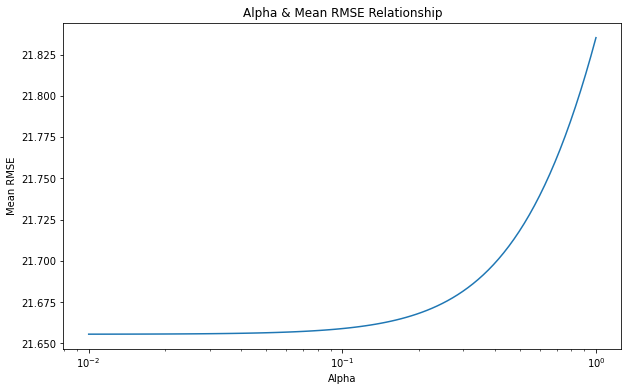

In [7]:
#Part 2b

RMSE = [] 

for i in ridge_alpha:
    model = Ridge(alpha=i)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    
    rms = np.mean(mean_squared_error(y_train, y_pred_train, squared=False))
    RMSE.append(rms)

plt.figure(figsize=(10, 6))
plt.plot(ridge_alpha,RMSE)
plt.xscale('log')
plt.title('Alpha & Mean RMSE Relationship')
plt.xlabel('Alpha')
plt.ylabel('Mean RMSE')
plt.show()

In [8]:
#Part 2c
r_pipeline = Pipeline([('scaler', StandardScaler()),
     ('ridge',Ridge(alpha=ridge.alpha_,random_state=42))] )
r_pipeline.fit(X_train,y_train)
y_pred_test = r_pipeline.predict(X_test)

test= mean_squared_error(y_train, y_pred_train, squared=False)

print("Test RMSE: ",test)

Test RMSE:  21.835272265032646


## Question 3 - Classification (35 pts)

### a) Binary target:
- Convert your target variable in the dataset into a binary variable using >= mean thresholding (use the same data splitting as before). 

### b) Build logistic regression model:
- Define a Logistic Regression model and report the resulting *training* precision and *testing* accuracy of your model. Make sure the set the maximum number of iterations for your model to 10000 (use pipeline for normalization and model building same as Questions 1 and 2).

### c) Build a Support Vector Machine (SVM) model:
- Define a linear SVM model with default options and maximum number of iterations 10000. Report the resulting *training* precision and *testing* accuracy of your model (use pipeline for normalization and model building same as Questions 1 and 2).


### d) Comparison:
- Compare the performance of your models in `b` and `c` in terms of generalization performance and execution time, what do you conclude? 

In [9]:
#Part 3a

thresh=y.mean()
binary_target = np.where(y >= thresh, 1, 0)
#assuming the data splitting is for binary
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, binary_target, test_size = 0.30, random_state = 42)

In [10]:
#Part 3b

pipeline = Pipeline([('scaler', StandardScaler()), ('model',LogisticRegression(max_iter=10000, random_state=42))])
#assuming we use binary variables
pipeline.fit(X_bin_train,y_bin_train)
y_bin_pred_test = pipeline.predict(X_bin_test)
y_bin_pred_train = pipeline.predict(X_bin_train)

train_per=precision_score(y_bin_train, y_bin_pred_train)
test_acc=accuracy_score(y_bin_test, y_bin_pred_test)

print("Resulting training precision: ", train_per,"\nResulting testing accuracy: ", test_acc)

Resulting training precision:  0.807841483979764 
Resulting testing accuracy:  0.8045560445249806


In [11]:
#Part 3c
#It says SVC but in the sklearn it says its ok
pipeline = Pipeline([('scaler', StandardScaler()), ('model',LinearSVC(max_iter=10000))])
#assuming we use binary variables
pipeline.fit(X_bin_train,y_bin_train)
y_bin_pred_test = pipeline.predict(X_bin_test)
y_bin_pred_train = pipeline.predict(X_bin_train)

train_per=precision_score(y_bin_train, y_bin_pred_train)
test_acc=accuracy_score(y_bin_test, y_bin_pred_test)

print("Resulting training precision: ", train_per,"\nResulting testing accuracy: ", test_acc)

Resulting training precision:  0.7866311455558247 
Resulting testing accuracy:  0.7912244369660886


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*Part 3d*

`Written Answer: In terms of the performance we can see that Logistic Regression is slightly better performing than Linear SVM. Execution time wise Logistic Regression was faster but I did come across an error for Linear SVM when outputting the results so I'm not sure if that increased the execution time in anyway. From what I have seen I conclude that overall Logistic Regression is the better model in terms of generalizing performance and execution time.`



`Reference List`

`“Accuracy_score.” Scikit Learn, scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html.

ankthon. “Drop Rows from Pandas Dataframe with Missing Values or Nan in Columns.” GeeksforGeeks, 2 July 2020, www.geeksforgeeks.org/drop-rows-from-pandas-dataframe-with-missing-values-or-nan-in-columns/.

Chauhan, Devesh. “Drop Empty Columns in Pandas.” Tutorialspoint, 5 May 2023, www.tutorialspoint.com/drop-empty-columns-in-pandas#:~:text=We%20can%20drop%20both%20regular,dropna()%E2%80%9D%20method.

Coots, Reed, et al. “Ridge Regression | Python.” GitHub, jbhender.github.io/Stats506/F17/Projects/G13/Python.html#:~:text=Ridge%20Regression%20cross%20validation%20can,optimal%20alpha%20value%20as%20shown.&text=The%20optimal%20alpha%20value%20for%20our%20analysis%20ends%20up%20being%2022.

Demirkesen, Yalim. “Applying Ridge Regression with Cross-Validation.” Medium, 2 May 2021, towardsdatascience.com/the-power-of-ridge-regression-4281852a64d6.

“LINEARSVC.” Scikit Learn, scikit-learn.org/dev/modules/generated/sklearn.svm.LinearSVC.html.

“Logisticregression.” Scikit Learn, scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html.

“Pandas DataFrame Drop() Method.” W3Schools, www.w3schools.com/python/pandas/ref_df_drop.asp#:~:text=The%20drop()%20method%20removes,method%20removes%20the%20specified%20row.

“Precision_score.” Scikit Learn, scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html.

“R2_score.” Scikit Learn, scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html.

Rao, Sathyanarayan. “Understanding Pipeline in Sklearn.” Kaggle, 2022, www.kaggle.com/code/sathyanarayanrao89/understanding-pipeline-in-sklearn.

“RIDGECV.” Scikit Learn, scikit-learn.org/dev/modules/generated/sklearn.linear_model.RidgeCV.html.

siamii, and Greg. “Is There a Library Function for Root Mean Square Error (RMSE) in Python?” Stack Overflow, 19 June 2013, stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python.

Tartaglia. “Using Standardization in Sklearn Pipeline.” Stack Overflow, 4 Jan. 2019, stackoverflow.com/questions/54034991/using-standardization-in-sklearn-pipeline.`



